In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# Function to split data into sequences
def spliter(data, size):
    x, y = [], []
    for i in range(len(data) - size):
        x.append(data[i: i + size, 0])
        y.append(data[i + size, 0])
    x = np.array(x)
    y = np.array(y)
    x = x[..., tf.newaxis]  # Add new axis for LSTM input compatibility
    return x, y

In [ ]:
# Load CSV file
df = pd.read_csv("your-dataset.csv")

# Data preprocessing
# price = df[["Date", "Close"]]
price = df[["Timestamp", "Close"]]
# price = price[price["Date"] >= "2021-01-01"]
close_price = price["Close"].values

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_price = scaler.fit_transform(close_price.reshape(-1, 1))

In [4]:
# Splitting the data into training and testing sets
train_size = int(len(close_price) * 0.8)
X_train, X_test = close_price[:train_size], close_price[train_size:]

# Splitting the data into sequences
x_train, y_train = spliter(X_train, 30)  # Using a window size of 20
x_test, y_test = spliter(X_test, 30)

In [5]:
# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(x_train.shape[1], 1), return_sequences=True, dropout=0.2))
model.add(LSTM(50, dropout=0.1))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])


c:\Users\Amirreza_Bazmi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), verbose=0, callbacks=[early_stop])

In [7]:
# Prediction
train_predicted = model.predict(x_train)
test_predicted = model.predict(x_test)

86773/86773 ━━━━━━━━━━━━━━━━━━━━ 536s 6ms/step
21693/21693 ━━━━━━━━━━━━━━━━━━━━ 138s 6ms/step


In [8]:
# Converting predictions back to original scale
train_predicted = scaler.inverse_transform(train_predicted)
test_predicted = scaler.inverse_transform(test_predicted)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1))

In [9]:
# Calculate RMSE and MAE
train_rmse = np.sqrt(mean_squared_error(original_ytrain, train_predicted))
test_rmse = np.sqrt(mean_squared_error(original_ytest, test_predicted))
train_mae = mean_absolute_error(original_ytrain, train_predicted)
test_mae = mean_absolute_error(original_ytest, test_predicted)

print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")

Train RMSE: 5343.394736556199, Test RMSE: 9356.19069486433
Train MAE: 4117.237151117199, Test MAE: 8582.493695552525


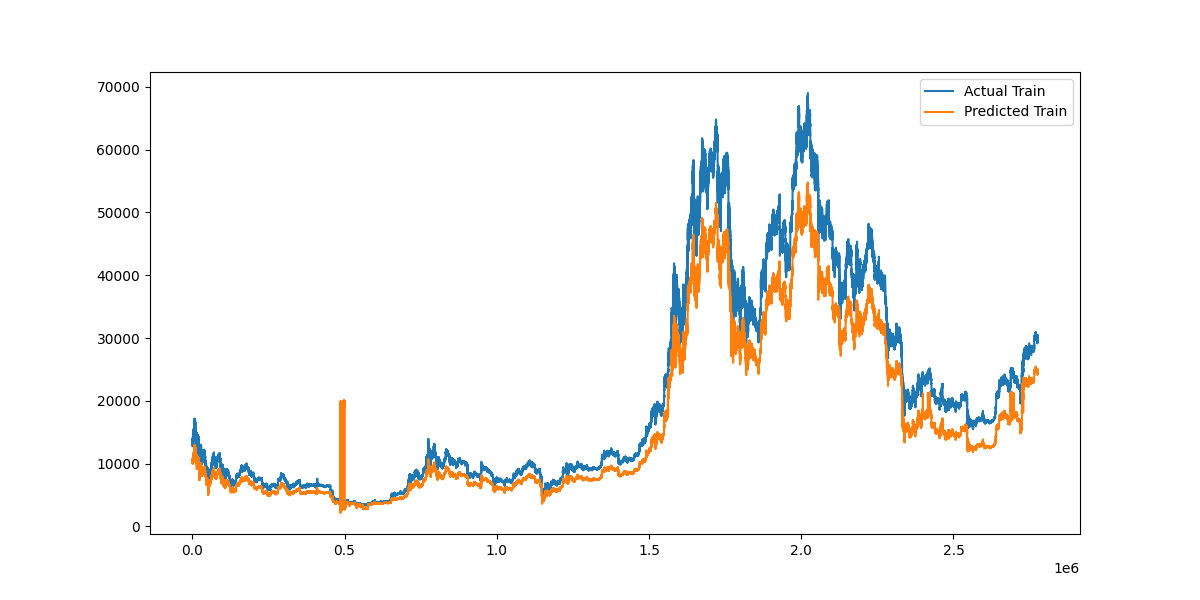

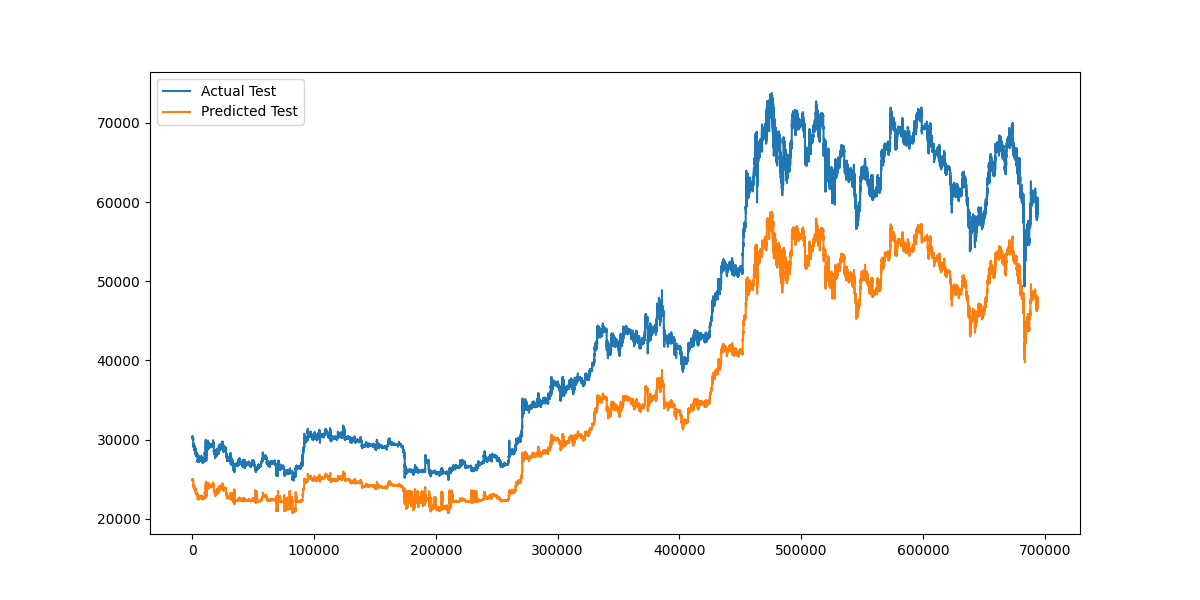

In [10]:
# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(original_ytrain, label='Actual Train')
plt.plot(train_predicted, label='Predicted Train')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(original_ytest, label='Actual Test')
plt.plot(test_predicted, label='Predicted Test')
plt.legend()
plt.show()

In [11]:
model.save("LSTM-BTC-1m.h5")